In [ ]:
import random

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from neural_bandits.bandits.neural_ucb_bandit import NeuralUCBBandit
from neural_bandits.benchmark.datasets.mnist import MNISTDataset
from neural_bandits.utils.data_storage import InMemoryDataBuffer, AllDataBufferStrategy
from neural_bandits.utils.data_sampler import SortedDataSampler

from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment
from neural_bandits.benchmark.logger_decorator import OnlineBanditLoggerDecorator

In [ ]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [ ]:
dataset = MNISTDataset()
print(dataset.context_size)
print(len(dataset))

network = Network(dataset.context_size * dataset.num_actions, hidden_size=100)

batch_size = 1
n_samples = 1000
indices = list(range(len(dataset)))
random.shuffle(indices)
subset_indices = indices[:n_samples]
mini_dataset = Subset(dataset, subset_indices)
print("Subset size:", len(mini_dataset))
sorted_sampler = SortedDataSampler(
    data_source=Subset(dataset, range(10000)),
    key_fn=lambda idx: int(dataset.y[idx]),
)

In [ ]:
buffer = InMemoryDataBuffer(
    buffer_strategy=AllDataBufferStrategy(),
    max_size=10000,
)

In [ ]:
train_loader = DataLoader(Subset(dataset, range(10000)), batch_size=batch_size, shuffle=True)
env = BanditBenchmarkEnvironment(train_loader)
bandit_module = NeuralUCBBandit(
    n_features = dataset.context_size * dataset.num_actions,
    network=network,
    buffer=buffer,
    batch_size=batch_size,
    early_stop_threshold=1e-3,
    num_grad_steps=1000,
    lambda_=0.00001,
    nu=0.00001,
    learning_rate=1e-4,
    train_interval=50,
    initial_train_steps=2000,
    max_grad_norm=20.0,
)

# logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(CSVLogger("logs", name="neural_ucb_bandit", flush_logs_every_n_steps=100))

In [ ]:
total_regret = 0
n_samples = 0

for contextualized_actions in env:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
    feedback = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)

    total_regret += batch_regret.sum().item()
    n_samples += batch_size
    
    logger.pre_training_log({"regret": batch_regret.sum().item(), "average_regret": total_regret / n_samples})

    batch_dataloader = DataLoader(feedback, batch_size=1)
    trainer.fit(bandit_module, batch_dataloader)

c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Step: 0 {'training_run': 9999, 'loss': 0.03460788354277611, 'reward': 1.0, 'epoch': 0, 'regret': 0.0, 'average_regret': 0.1478}86868686868687}}

In [7]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:10000])
cumulative_regret = np.cumsum(metrics["regret"][:10000].dropna())

logs\neural_ucb_bandit\version_7/metrics.csv


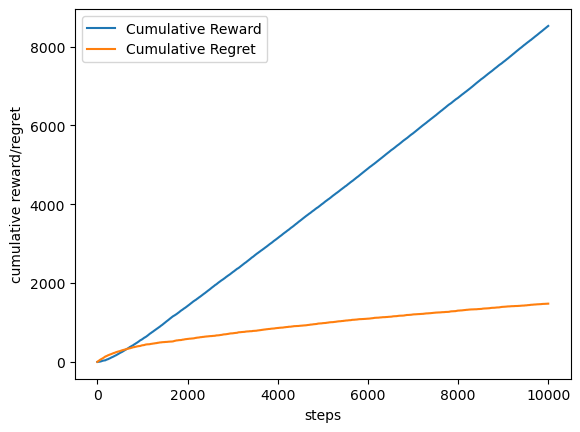

In [8]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward, label='Cumulative Reward')
plt.plot(cumulative_regret, label='Cumulative Regret')
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [9]:
# average reward
print(sum(metrics["reward"][:10]) / 10)
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:10000]) / 10000)

print(sum(metrics["regret"][:10].dropna()) / 10)
print(sum(metrics["regret"][:100].dropna()) / 100)
print(sum(metrics["regret"][:10000].dropna()) / 10000)

0.0
0.21
0.8522
1.0
0.79
0.1478


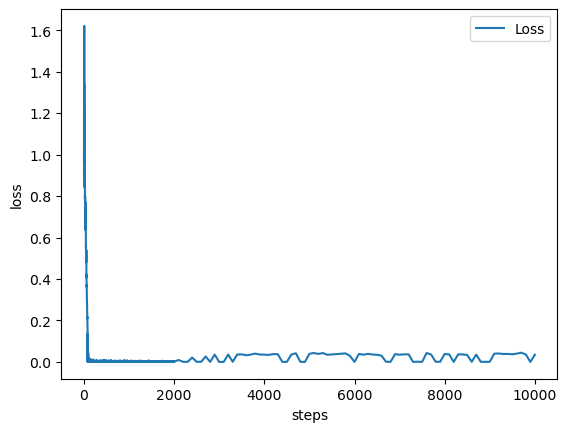

In [10]:
plt.plot(metrics["loss"][:10000].dropna(), label='Loss')
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()